# LUAD CPTAC analysis

In [61]:
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from msresist.figures.figure3 import plotR2YQ2Y, plotclustersIndividually
from msresist.figures.figure1 import pca_dfs, plotClustergram
from msresist.pre_processing import preprocessing, filter_NaNpeptides, MeanCenter, Log2T
from msresist.clustering import MassSpecClustering
from msresist.motifs import MapMotifs, FormatName
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.2, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Import and Preprocess Data

In [3]:
# X = preprocessing(CPTAC=True, log2T=True)
X = pd.read_csv("msresist/data/MS/CPTAC/CPTAC-preprocessedMotfis.csv").iloc[:, 1:]

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

In [4]:
X.head()

,Sequence,Protein,Gene,Position,C3N.01799,C3N.01799.N,C3L.01890,C3L.01890.N,C3N.00572,C3N.00572.N,...,C3N.02003.N,C3N.02379.N,C3N.00175,C3N.00175.N,C3N.01823,C3N.01823.N,C3L.02549,C3L.02549.N,C3L.02365,C3L.02365.N
0,AAAAAsGGGVS,NP_002577.2,PBX2,S146-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAAAAsQQGSA,NP_001308122.1,TBL1XR1,S119-p,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.372907,-0.979491,-0.083036,-0.361962,1.275506,-0.568015,0.25423,-0.378522,0.987749,-0.189486
2,AAAAAsTQAQQ,NP_001035540.1,MINDY2,S575-p,0.012034,-0.630863,-1.159479,-0.740044,0.107228,-0.016971,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAAAGsASPRS,NP_064520.2,WRNIP1,S151-p,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAAGsGPSPP,NP_060895.1,PI4K2A,S44-p,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.063300,-0.647500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Distribution of Missingness

In [5]:
p_nan_counts = []
for i in range(d.shape[1]):
    p_nan_counts.append(np.count_nonzero(np.isnan(d[i])))

distribution mean: 152.76464620248686


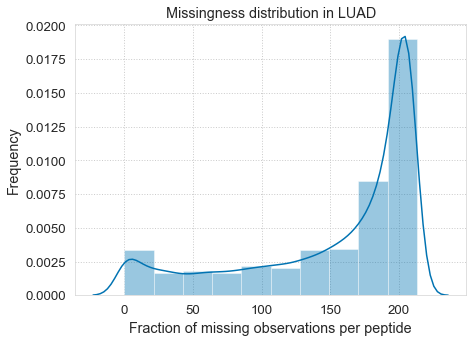

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax = sns.distplot(p_nan_counts, 10)
ax.set_title("Missingness distribution in LUAD")
ax.set_ylabel("Frequency")
ax.set_xlabel("Fraction of missing observations per peptide")

print("distribution mean:", np.mean(p_nan_counts))

### Filter peptides based on a threshold of missingness

In [7]:
X_f = filter_NaNpeptides(X, cut=1)
d_f = X_f.select_dtypes(include=['float64']).T
i_f = X_f.select_dtypes(include=['object'])

## Compare White vs Broad Quantitation

### Import White data set and Find matching values in full CPTAC data set

Import White data set:

In [8]:


white = pd.read_csv("msresist/data/MS/CPTAC/03CPTAC_filtered_White.csv").iloc[:-1, :]

Extract gene names from full protein description:

In [9]:
def FormatName(X):
    """ Keep only the general protein name, without any other accession information """
    genes = []
    counter = 0
    for v in X.iloc[:, 0]:
        if "GN" not in v:
            counter += 1
            continue
        genes.append(v.split("GN=")[1].split(" PE")[0].strip())
    print("number of proteins without gene name:", counter)
    return genes

In [10]:
genes = FormatName(white)
white = white.set_index("Protein").drop("Uncharacterized protein FLJ45252 OS=Homo sapiens OX=9606 PE=2 SV=2").reset_index()
white = white.drop("Protein", axis=1)
white.insert(1, "Gene", genes)

number of proteins without gene name: 1


Process sequences to generate +/- 5 motifs:

In [11]:
white = MapMotifs(white, white.iloc[:, 1]).drop("Position", axis=1).iloc[:, :10]

16/4669 peptides were not found in the proteome.
4653


In [12]:
white = MeanCenter(Log2T(white, list(white.columns[2:])), list(white.columns[2:]), mc_row=True, mc_col=False).sort_values(by="Sequence")

In [13]:
white.shape

(4595, 10)

Find matching patients of CPTAC data set:

In [14]:
WhiteCols = ["C3N.02587", "C3N.02587.N", "C3L.00893", "C3L.00893.N", "C3N.01488", "C3N.01488.N", "C3N.01413", "C3N.01413.N"]
cols = [X.columns[0]] + [X.columns[2]] + WhiteCols
X_tmt3 = X[cols].dropna().sort_values(by="Sequence")

Find matching peptides of CPTAC data set

In [15]:
X_tmt3 = X_tmt3.set_index(["Gene", "Sequence"])
rows = []
counter = 0
for idx in range(white.shape[0]):
    try:
        r = X_tmt3.loc[white["Gene"][idx], white["Sequence"][idx]].reset_index()
        if len(r) > 1:
            rows.append(pd.DataFrame(r.iloc[0, :]).T)
        else:
            rows.append(r)
    except:
        counter += 1
        continue
print("Number of mismatches: ", counter)

Number of mismatches:  3673


In [16]:
X_white = pd.concat(rows)
X_white = X_white.set_index(np.arange(X_white.shape[0]))

In [17]:
X_white.shape

(922, 10)

In [18]:
white = white.set_index(["Gene", "Sequence"])
rows = []
counter = 0
for idx in range(X_white.shape[0]):
    try:
        r = white.loc[X_white["Gene"][idx], X_white["Sequence"][idx]].reset_index()
        if len(r) > 1:
            rows.append(pd.DataFrame(r.iloc[0, :]).T)
        else:
            rows.append(r)
    except:
        counter += 1
print(counter)

0


In [19]:
White_X = pd.concat(rows)

In [20]:
X_white = X_white.drop_duplicates(list(X_white.columns), keep="first")

In [21]:
White_X = White_X.drop_duplicates(list(White_X.columns), keep="first")

### Heatmaps

BROAD QUANTIFICATION

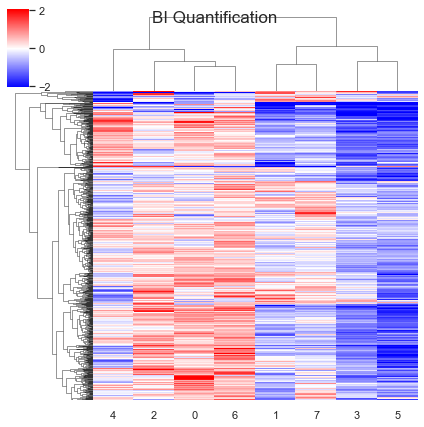

In [22]:
XW_ = X_white.set_index(["Gene"]).iloc[:, 1:]
XW_ = np.array(XW_, dtype="float64")
plotClustergram(XW_, "BI Quantification", np.max(np.abs(XW_)) * 0.3, figsize=(6,6))

WHITE QUANTIFICATION

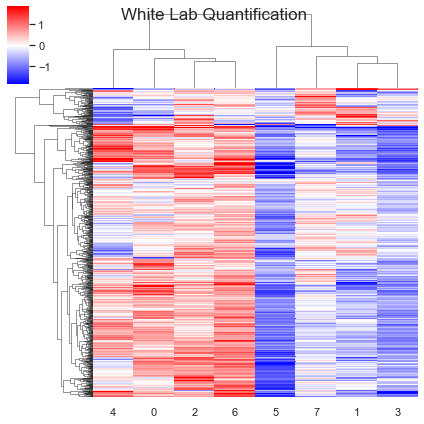

In [23]:
WX_ = White_X.set_index(["Gene"]).iloc[:, 1:]
WX_ = np.array(WX_, dtype="float64")
plotClustergram(WX_, "White Lab Quantification", np.max(np.abs(WX_)) * 0.6, figsize=(6,6))

### Model

#### BROAD

In [32]:
for i in range(2, X_white.shape[1]):
    X_white.iloc[:, i] = pd.to_numeric(X_white.iloc[:, i], errors="ignore")

In [33]:
Xd = X_white.iloc[:, 2:].T
Xi = X_white.iloc[:, :2]

In [44]:
distance_method = "PAM250"
ncl = 9
SeqWeight = 10

In [45]:
X_model = MassSpecClustering(Xi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Xd, "NA")

init
initialized
Compute all pairwise distances
pairwise distances matrix ready
start EM
__________________________________________
N_ITER: 0
9
Cluster sizes: [11, 1, 131, 37, 9, 337, 2, 165, 112]
39.326008100033285
SeqWins: 386 DataWins: 336 BothWin: 40 MixWin: 43
__________________________________________
N_ITER: 1
9
Cluster sizes: [19, 182, 16, 46, 67, 142, 139, 129, 65]
40.52893938468409
SeqWins: 222 DataWins: 428 BothWin: 125 MixWin: 30
__________________________________________
N_ITER: 2
9
Cluster sizes: [26, 35, 51, 75, 105, 185, 48, 136, 144]
48.02932017189908
SeqWins: 244 DataWins: 424 BothWin: 122 MixWin: 15
__________________________________________
N_ITER: 3
9
Cluster sizes: [30, 68, 51, 84, 97, 160, 61, 112, 142]
51.493365334769294
SeqWins: 243 DataWins: 408 BothWin: 125 MixWin: 29
__________________________________________
N_ITER: 4
9
Cluster sizes: [33, 76, 54, 83, 85, 149, 85, 99, 141]
54.25928104185877
SeqWins: 252 DataWins: 384 BothWin: 147 MixWin: 22
________________

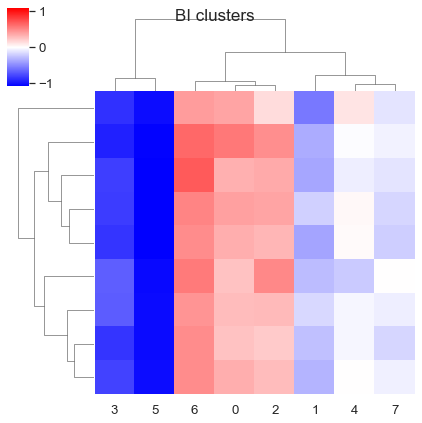

In [124]:
plotClustergram(Xcenters, "BI clusters", max(np.max(np.abs(Xcenters))) * 0.9, figsize=(6,6))

#### Cluster Averages

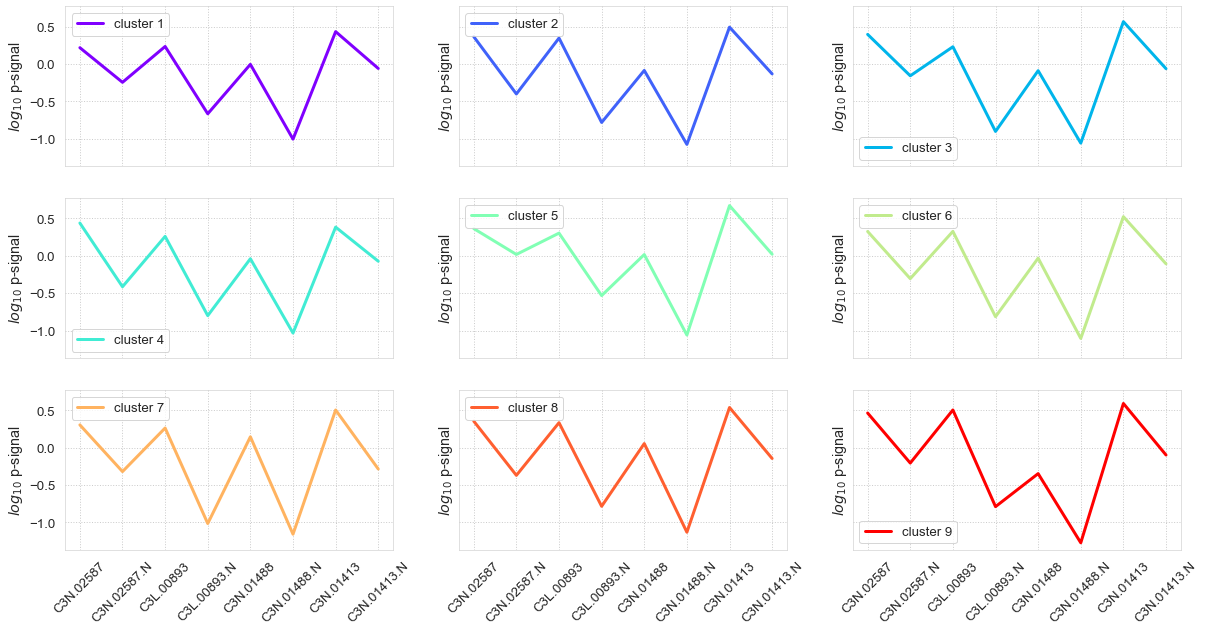

In [126]:
plotclustersIndividually(Wcenters, X_white.columns[2:], 3, 3)

#### PCA

In [83]:
Xcenters["Patient_ID"] = X_white.columns[2:]
Xcenters = Xcenters.set_index("Patient_ID")

In [87]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(Xcenters.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, Xcenters, c, ["Patient_ID"], "Cluster")

In [88]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [90]:
varExp = np.round(pp.explained_variance_ratio_, 2)
varExp

array([0.98, 0.01])

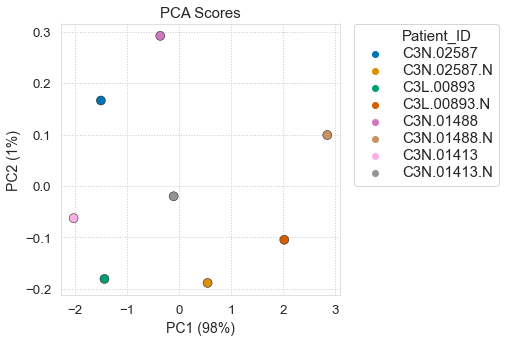

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Patient_ID", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

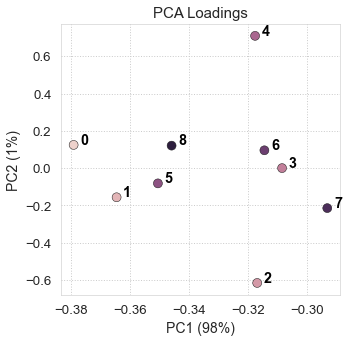

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.005, dLoad_.iloc[line, 1]+0.005, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

#### WHITE Lab

In [99]:
for i in range(2, White_X.shape[1]):
    White_X.iloc[:, i] = pd.to_numeric(White_X.iloc[:, i], errors="ignore")

In [100]:
Wd = White_X.iloc[:, 2:].T
Wi = White_X.iloc[:, :2]

In [102]:
w_model = MassSpecClustering(Wi, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(Wd, "NA")

init
initialized
Compute all pairwise distances
pairwise distances matrix ready
start EM
__________________________________________
N_ITER: 0
9
Cluster sizes: [10, 2, 10, 2, 11, 567, 1, 196, 6]
50.65971874626449
SeqWins: 299 DataWins: 443 BothWin: 47 MixWin: 16
__________________________________________
N_ITER: 1
9
Cluster sizes: [12, 89, 13, 77, 11, 320, 139, 137, 7]
51.74996228202246
SeqWins: 111 DataWins: 607 BothWin: 66 MixWin: 21
__________________________________________
N_ITER: 2
9
Cluster sizes: [20, 60, 17, 19, 15, 437, 34, 190, 13]
56.89819117884019
SeqWins: 174 DataWins: 553 BothWin: 61 MixWin: 17
__________________________________________
N_ITER: 3
9
Cluster sizes: [28, 64, 19, 49, 15, 367, 73, 168, 22]
56.38880397615874
SeqWins: 168 DataWins: 546 BothWin: 70 MixWin: 21
__________________________________________
N_ITER: 4
9
Cluster sizes: [32, 78, 22, 38, 15, 352, 83, 159, 26]
57.360064799910305
SeqWins: 160 DataWins: 556 BothWin: 77 MixWin: 12
_____________________________

In [103]:
Wcenters = w_model.transform(Xd).T

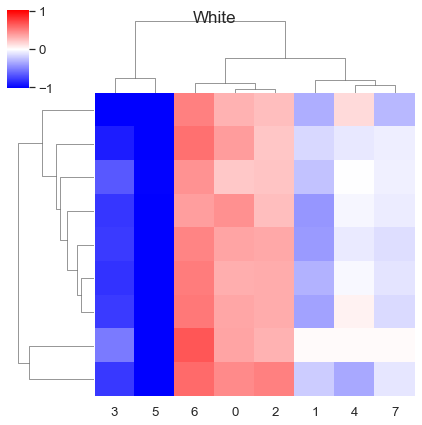

In [125]:
plotClustergram(Wcenters, "White", max(np.max(np.abs(Wcenters))) * 0.8, figsize=(6,6))

#### Cluster Averages

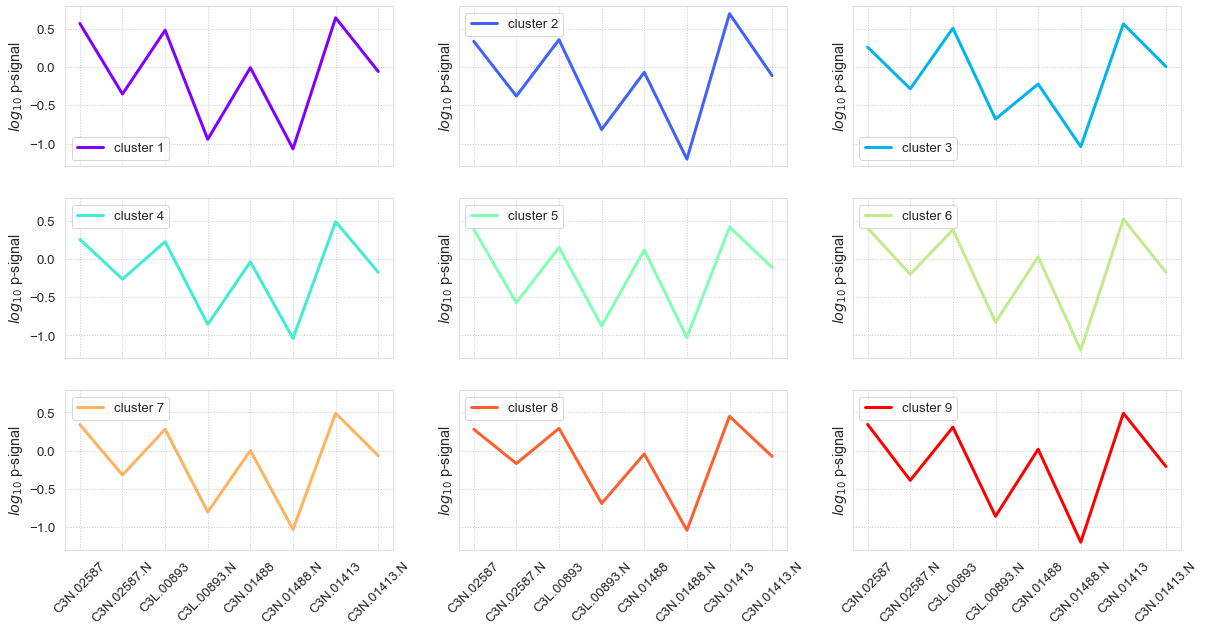

In [72]:
plotclustersIndividually(Wcenters, X_white.columns[2:], 3, 3)

#### PCA

In [128]:
Wcenters = Wcenters.T

In [129]:
Wcenters["Patient_ID"] = X_white.columns[2:]

In [133]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(Wcenters.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, Wcenters, c, ["Patient_ID"], "Cluster")

In [134]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [135]:
varExp = np.round(pp.explained_variance_ratio_, 2)
varExp

array([0.98, 0.01])

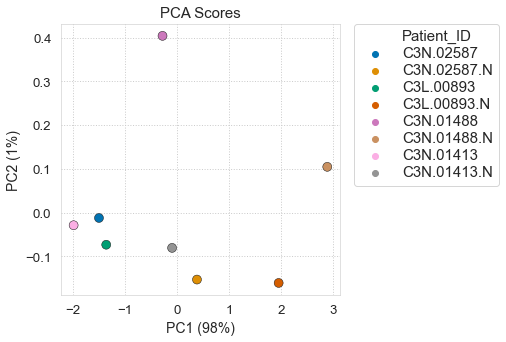

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Patient_ID", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

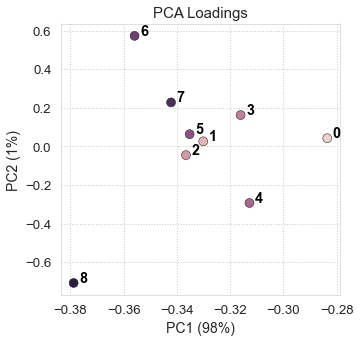

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.005, dLoad_.iloc[line, 1]+0.005, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

## Run Model

Reduce data set:

In [ ]:
# Reduce data set?
# npept = 7000
# d = d.iloc[:, :npept]
# i = i.iloc[:npept, :]

#Drop NaN?
# d = d.iloc[:8, :].dropna(axis=1)
# i = i.iloc[d.columns, :]

In [ ]:
centers

Run model:

In [ ]:
%%time
distance_method = "PAM250"
ncl = 20
SeqWeight = 50

MSC = MassSpecClustering(i_f, ncl, SeqWeight=SeqWeight, distance_method=distance_method, n_runs=1).fit(d_f, "NA")

Save model:

In [ ]:
import pickle
with open('CPTACmodel', 'wb') as f:
    pickle.dump([MSC], f)

Load if necessary:

In [ ]:
# with open('CPTACmodel', 'rb') as f:
#     msc_foo = pickle.load(f)

## Hierarchical Clustering

In [ ]:
centers = MSC.transform(d_f)
centers["Patient_ID"] = X.columns[4:]

In [ ]:
from msresist.figures.figure1 import plotClustergram
import seaborn as sns
centers = centers.set_index(["Patient_ID"])
plotClustergram(centers, "", lim=max(np.max(np.abs(centers)) * 0.5), figsize=(10, 10))
centers = centers.reset_index()
# plt.savefig("CPTAC_GMM.svg", bbox_inches='tight', format='svg', dpi=1200)

## Regression against Clinical Features

Import 2y-Survival data:

In [ ]:
cf = pd.read_csv("msresist/data/MS/CPTAC/Y_CPTAC.csv").drop("Metastasis", axis=1)
cf_ = cf.replace("Living", 0)
cf_ = cf_.replace("Deceased", 1)
cf_ = cf_.replace("No", 0)
cf_ = cf_.replace("Yes", 1)

In [ ]:
cf_.shape

Import patient accessions to match signaling with clinical data:

In [ ]:
IDict = pd.read_csv("msresist/data/MS/CPTAC/IDs.csv", header=0)
IDict_ = dict(zip(IDict.iloc[:, 0], IDict.iloc[:, 1]))

Change patient IDs from Case ID to Broad ID:

In [ ]:
ids = []
for i in range(cf.shape[0]):
    ids.append(IDict_[cf_.iloc[i, 0]])
cf_["Patient_ID"] = ids

Add Tumor row per patient:

In [ ]:
for i in range(cf_.shape[0]):
    id_ = cf_.iloc[i, 0].split(".N")[0]
    cf_.loc[-1] = [id_, cf_.iloc[i, 1]]
    cf_.index = cf_.index + 1
cf_.loc[-1] = ["C3N.02379.1", 0]
cf_.index = cf_.index + 1
cf_ = cf_.sort_index()

In [ ]:
centers.head()

In [ ]:
centers = centers.set_index("Patient_ID").drop(["C3N.02587", "C3N.02587.N"], axis=0).sort_values(by="Patient_ID")
y = pd.read_csv("msresist/data/MS/CPTAC/y.csv").sort_values(by="Patient_ID").set_index("Patient_ID")

### R2Y/Q2Y

In [ ]:
p1 = PLSRegression(n_components=2, scale=False)
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, p1, centers, y, 1, 10)

In [ ]:
centers = centers.reset_index()

## PCA Analysis

In [ ]:
c=2
pp = PCA(n_components=c)
dScor_ = pp.fit_transform(centers.iloc[:, 1:])
dLoad_ = pp.components_
dScor_, dLoad_ = pca_dfs(dScor_, dLoad_, centers, c, ["Patient_ID"], "Cluster")

In [ ]:
dScor_.columns = ["PC1", "PC2", "Patient_ID"]

In [ ]:
tumortype = []
for i in range(dScor_.shape[0]):
    if ".N" in dScor_["Patient_ID"][i]:
        tumortype.append("Normal")
    else:
        tumortype.append("Tumor")

In [ ]:
dScor_["Type"] = tumortype

In [ ]:
varExp = np.round(pp.explained_variance_ratio_, 2)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dScor_, hue="Type", style="Type", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
ax.set_title("PCA Scores", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, labelspacing=0.2, fontsize=15);
# plt.savefig("PCA_CPTAC_20cl_Scores.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x="PC1", y="PC2", data=dLoad_, hue="Cluster", ax=ax, s=80, **{'linewidth':.5, 'edgecolor':"k"})
for line in range(0, dLoad_.shape[0]):
     ax.text(dLoad_.iloc[line, 0]+0.001, dLoad_.iloc[line, 1]+0.009, dLoad_["Cluster"][line], horizontalalignment='right', size='medium', color='black', weight='semibold')
ax.legend().remove()
ax.set_title("PCA Loadings", fontsize=15)
ax.set_xlabel("PC1 (" + str(int(varExp[0] * 100)) + "%)", fontsize=14)
ax.set_ylabel("PC2 (" + str(int(varExp[1] * 100)) + "%)", fontsize=14);
# plt.savefig("PCA_CPTAC_20cl_Loadings.svg", bbox_inches='tight', format='svg', dpi=1200)

In [ ]:
clustermembers = MSC.clustermembers(X_f.T)
clustermembers.head(5)